# Bank Churn Customer Prediction #

## Context ##
As we know, it is much more expensive to sign in a new client than keeping an existing one.
It is advantageous for banks to know what leads a client towards the decision to leave the company.
Churn prevention allows companies to develop loyalty programs and retention campaigns to keep as many customers as possible. 

Can you predict whether or not a bank customer leave in next cycle ?
We will use a bank turnover dataset to analyze, this data come from kaggle.com: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling



## Data content ##

* RowNumber—corresponds to the record (row) number and has no effect on the output.
* CustomerId—contains random values and has no effect on customer leaving the bank.
* Surname—the surname of a customer has no impact on their decision to leave the bank.
* CreditScore—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
* Geography—a customer’s location can affect their decision to leave the bank.
* Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.
* Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
* Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
* Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
* NumOfProducts—refers to the number of products that a customer has purchased through the bank.
* HasCrCard—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
* IsActiveMember—active customers are less likely to leave the bank.
* EstimatedSalary—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
* Exited—whether or not the customer left the bank.

## Solution ##

This is a classification problem, so we will apply following algorithms to build the prediction model:

* KNN
* Logistic Regression
* Support Vector Machine
* Decison Tree
* Random Forest
* XGBoost
* Naive Bayes
* ANN

Before building the model, we will perfom:
* Data wrangling
* Exploratory Data Analysis
* Feature Engineering

After gain the results of different algorithms, we will evalute their performance by score to find the best.

In [2]:
#Import the useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split # For train/test splits
from sklearn.neighbors import KNeighborsClassifier # The k-nearest neighbor classifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.pipeline import Pipeline # For setting up pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV # For optimization
from sklearn.metrics import accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier

In [3]:
# Convert categorical variable into dummy/indicator variables
# Arguments: 
# df_object is a categorical dataframe
# df_number is a number dataframe
# Return: add dummies to df_number with prefix of columns
def add_dummies(df_number,df_object):
    column_names = df_object.columns
    prefix_names = []
    for col in column_names:
        prefix_names.append(col + '_') 
    df_dummies = pd.get_dummies(df_object, prefix=prefix_names, columns=column_names)
    # Add dummies to result dataframe
    return pd.concat([df_dummies,df_number], axis=1)

In [4]:
# Plot heatmap for number data
# Arguments: df is a number dataframe
def plot_heatmap(df):
    # Correlation between different variables
    corr = df.corr()
    # Set up the matplotlib plot configuration
    f, ax = plt.subplots(figsize=(12, 10))
    # Draw the heatmap
    sns.heatmap(corr, annot=True)

In [5]:
# Draw boxplot distribution of number data
def draw_boxplot(df):
    for col in df.columns:
        df[[col]].plot(kind='box')

In [6]:
# Get the best features from the correlation between variables and target
# Arguments: 
# df_corr is a dataframe "One column" of correlation between variables and target, 
# the only column is target variable in df_corr
# negative_threshold: - threshold of correlation to get best features which is inverse relationship with target
# negative_threshold: + threshold of correlation to get best features which is positive relationship with target
# Return: a list of best features to analyze
def get_best_features(df_corr, negative_threshold, positive_threshold):
    best_corr_with_target = df_corr[((df_corr.iloc[:,0]>positive_threshold) 
                                    | (df_corr.iloc[:,0]<negative_threshold)) 
                                    & (df_corr.iloc[:,0]!=1)]
    list_best_features = best_corr_with_target.index.to_list()
    return list_best_features

In [7]:
# Tuning parameters to fine the best model among Logistic Regression, Random Forest and Support Vector Machine
def find_best_model_lr_rf_svm(X_train, y_train, X_test, y_test):
    # Create pipelines
    # Logistic Regression pipeline
    pipe_lr = Pipeline([('std', StandardScaler()),('mdl', LogisticRegression(random_state=42))])
    # Random Forest pipeline
    pipe_rf = Pipeline([('std', StandardScaler()),('mdl', RandomForestClassifier(random_state=42))])
    # SVM pipeline
    pipe_svm = Pipeline([('std', StandardScaler()),('mdl', svm.SVC(random_state=42))])

    # Set parameters for gridsearchs
    para_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    para_range_fl = [1.0, 0.5, 0.1]
    jobs = -1

    gr_para_lr = [{'mdl__penalty': ['l1', 'l2'],
                       'mdl__C': para_range_fl,
                       'mdl__solver': ['liblinear']}] 

    gr_para_rf = [{'mdl__criterion': ['gini', 'entropy'],
                       'mdl__min_samples_leaf': para_range,
                       'mdl__max_depth': para_range,
                       'mdl__min_samples_split': para_range[1:]}]

    gr_para_svm = [{'mdl__kernel': ['linear', 'rbf'], 
                        'mdl__C': para_range}]

    # Create gridsearches
    # Logistic Regression gridsearch
    gr_lr = GridSearchCV(estimator=pipe_lr, param_grid=gr_para_lr, scoring='accuracy', cv=10) 
    # Random Forest gridsearch
    gr_rf = GridSearchCV(estimator=pipe_rf, param_grid=gr_para_rf, scoring='accuracy', cv=10, n_jobs=jobs)
    # SVM gridsearch
    gr_svm = GridSearchCV(estimator=pipe_svm, param_grid=gr_para_svm, 
                          scoring='accuracy', cv=10, n_jobs=jobs)

    # List of pipelines to loop
    list_gridsearch = [gr_lr, gr_rf, gr_svm]

    # Dictionary of pipelines and classifier types for ease of reference
    models_dict = {0: 'Logistic Regression', 
                   1: 'Random Forest', 
                   2: 'Support Vector Machine'}

    # Training to find the best model
    print('Building models to find the best...')
    best_score = 0.0
    index_best_model = 0
    best_grid = ''
    for index, gr in enumerate(list_gridsearch):
        print('\nModel: %s' % models_dict[index])
        # Grid search fit data
        gr.fit(X_train, y_train)
        # Print best parameters
        print('Best parameters: %s' % gr.best_params_)
        # Print best training score
        print('Training score with best parameters: %.3f' % gr.best_score_)
        # Predict on test data with best parameters
        y_pred = gr.predict(X_test)
        # Print test data score of best model with best parameters
        print('Testing score with best parameters: %.3f ' % accuracy_score(y_test, y_pred))
        # Find best model which have highest testing score (highest accuracy)
        if accuracy_score(y_test, y_pred) > best_score:
            best_score = accuracy_score(y_test, y_pred)
            best_grid = gr
            index_best_model = index
    print('\nThe best model with highest accuracy on testing data: %s' % models_dict[index_best_model])


In [8]:
# Tuning parameters to fine the best model among KNN, Decision Tree, Naive Bayes and XGBoost
def find_best_model_knn_dt_nb_xgb(X_train, y_train, X_test, y_test):
    # Create pipelines
    # KNN pipeline
    pipe_knn = Pipeline([('std', StandardScaler()),('mdl', KNeighborsClassifier())])
    # Decision Tree pipeline
    pipe_dt = Pipeline([('std', StandardScaler()),('mdl', DecisionTreeClassifier())])
    # Naive Bayes pipeline
    pipe_nb = Pipeline([('std', StandardScaler()),('mdl', GaussianNB())])
    # XGBoost pipeline
    pipe_xgb = Pipeline([('std', StandardScaler()),('mdl', XGBClassifier(use_label_encoder=False))])

    # Set parameters for gridsearchs
    para_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    para_range_fl = [1.0, 0.5, 0.1]
    jobs = -1

    gr_para_knn = [{ 'mdl__n_neighbors' : [5,7,9,11,13,15],
                   'mdl__weights' : ['uniform','distance'],
                   'mdl__metric' : ['minkowski','euclidean','manhattan'],
                   'mdl__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}]

    gr_para_dt = [{'mdl__criterion': ['gini', 'entropy'],
                       'mdl__min_samples_leaf': para_range,
                       'mdl__max_depth': para_range,
                       'mdl__min_samples_split': para_range[1:]}]

    gr_para_nb = [{'mdl__var_smoothing': np.logspace(0,-9, num=100)}]

    gr_para_xgb = [{'mdl__objective' : ['binary:logistic'],
                       'mdl__n_estimators' : [50, 100, 150, 200],
                       'mdl__eta': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                       'mdl__max_depth': para_range,
                       'mdl__sampling_method': ['uniform','gradient_based'],
                       'mdl__eval_metric' : ['logloss']}]


    # Create gridsearches
    # KNN gridsearch
    gr_knn = GridSearchCV(estimator=pipe_knn, param_grid=gr_para_knn, scoring='accuracy', cv=10, n_jobs=jobs) 
    # Decision Tree gridsearch
    gr_dt = GridSearchCV(estimator=pipe_dt, param_grid=gr_para_dt, scoring='accuracy', cv=10, n_jobs=jobs)
    # Naive Bayes gridsearch
    gr_nb = GridSearchCV(estimator=pipe_nb, param_grid=gr_para_nb, 
                          scoring='accuracy', cv=10, n_jobs=jobs)
    # XGBoost gridsearch
    gr_xgb = GridSearchCV(estimator=pipe_xgb, param_grid=gr_para_xgb, 
                          scoring='accuracy', cv=10, n_jobs=jobs)


    # List of pipelines to loop
    list_gridsearch = [gr_knn, gr_dt, gr_nb, gr_xgb]

    # Dictionary of pipelines and classifier types for ease of reference
    models_dict = {0: 'KNN', 
                   1: 'Decision Tree', 
                   2: 'Gaussian Naive Bayes',
                   3: 'XGBoost'}

    # Training to find the best model
    print('Building models to find the best...')
    best_score = 0.0
    index_best_model = 0
    best_grid = ''
    for index, gr in enumerate(list_gridsearch):
        print('\nModel: %s' % models_dict[index])
        # Grid search fit data
        gr.fit(X_train, y_train)
        # Print best parameters
        print('Best parameters: %s' % gr.best_params_)
        # Print best training score
        print('Training score with best parameters: %.3f' % gr.best_score_)
        # Predict on test data with best parameters
        y_pred = gr.predict(X_test)
        # Print test data score of best model with best parameters
        print('Testing score with best parameters: %.3f ' % accuracy_score(y_test, y_pred))
        # Find best model which have highest testing score (highest accuracy)
        if accuracy_score(y_test, y_pred) > best_score:
            best_score = accuracy_score(y_test, y_pred)
            best_grid = gr
            index_best_model = index
    print('\nThe best model with highest accuracy on testing data: %s' % models_dict[index_best_model])


In [9]:
# Initial a classification ANN Model 
def init_ann(optimizer_set, number_neurons_set):
    from keras.models import Sequential
    from keras.layers import Dense
    
    # Creating the classifier ANN model
    ann = Sequential()
    ann.add(Dense(units=number_neurons_set, input_dim=9, kernel_initializer='uniform', activation='relu'))
    ann.add(Dense(units=number_neurons_set, kernel_initializer='uniform', activation='relu'))
    ann.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    ann.compile(optimizer=optimizer_set, loss='binary_crossentropy', metrics=['accuracy'])
            
    return ann

In [10]:
# Get the best parameters of ANN Model
def find_best_param_ann(X_train, y_train, X_test, y_test):
    jobs = -1
    
    parameters_ann = {'batch_size':[10,20,30],
                          'epochs':[10,20],
                        'optimizer_set':['adam', 'rmsprop'],
                      'number_neurons_set': [5,10]
                     }
  
    '''
    parameters_ann = {'batch_size':[20],
                          'epochs':[10],
                        'optimizer_set':['adam'],
                      'number_neurons_set':[10]
                     }
    '''
    # Create the classifier ANN Model
    ann_model = KerasClassifier(init_ann, verbose=0)

    # Creating the Grid search
    grid_search = GridSearchCV(estimator=ann_model, param_grid=parameters_ann, scoring='accuracy', cv=10, n_jobs=jobs)
    # Running Grid Search for different paramenters
    grid_search.fit(X_train,y_train, verbose=1)
    # Predict y
    y_pred = grid_search.predict(X_test)
    print('***** ANN Model ********')
    print('The best parameters of ANN Model: ', grid_search.best_params_)
    # Print best training score
    print('Training score with best parameters: %.3f' % grid_search.best_score_)
    # Print test data score of best model with best parameters
    print('Testing score with best parameters: %.3f ' % accuracy_score(y_test, y_pred))
   

In [11]:
# Read data from a file .csv to dataframe
#df = pd.read_csv('~/Documents/Data_Science/Assignment/Classification/Churn_Bank/Churn_Modelling.csv')
url = 'https://github.com/longevite8/Data-Science/blob/main/Churn_Modelling.csv?raw=true'
df = pd.read_csv(url)


In [12]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [14]:
# Check duplicate data value
df[df['CustomerId'].duplicated() == True].value_counts

<bound method DataFrame.value_counts of Empty DataFrame
Columns: [RowNumber, CustomerId, Surname, CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited]
Index: []>

In [15]:
# Descriptive Statistics for all columns
df.describe(include='all')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


In [16]:
df['Geography'].value_counts()


France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [17]:
df_number = df.select_dtypes(exclude=['object'])
# 'RowNumber' and 'CustomerId' have no effect on the output, so we drop them
df_number = df_number.drop(columns=['RowNumber', 'CustomerId'])
df_number

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,42,2,0.00,1,1,1,101348.88,1
1,608,41,1,83807.86,1,0,1,112542.58,0
2,502,42,8,159660.80,3,1,0,113931.57,1
3,699,39,1,0.00,2,0,0,93826.63,0
4,850,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0
9996,516,35,10,57369.61,1,1,1,101699.77,0
9997,709,36,7,0.00,1,0,1,42085.58,1
9998,772,42,3,75075.31,2,1,0,92888.52,1


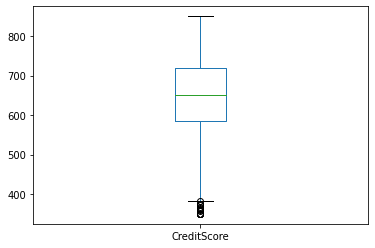

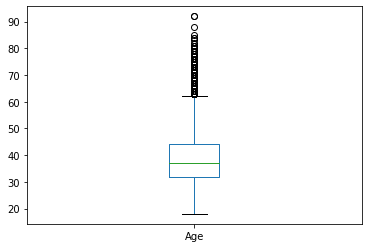

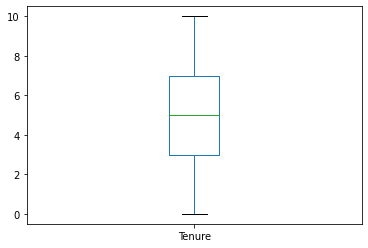

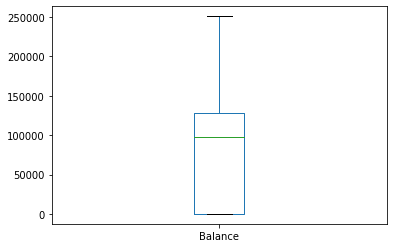

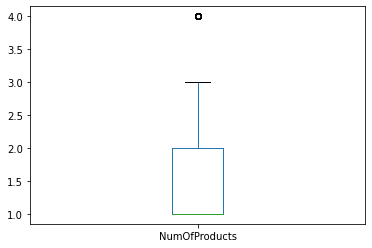

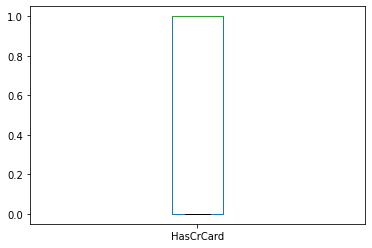

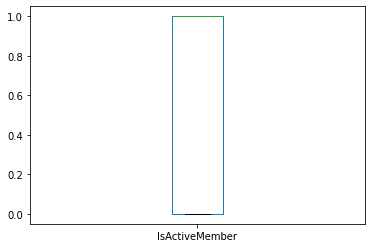

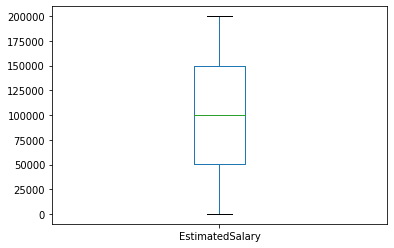

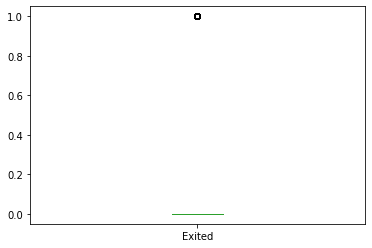

In [18]:
# Draw boxplot distribution of number data
draw_boxplot(df_number)

In [19]:
df_object = df.select_dtypes(include=['object'])
# 'Surname' have no effect on the output, so we drop it
df_object = df_object.drop(columns=['Surname'])
df_object

,Geography,Gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
4,Spain,Female
...,...,...
9995,France,Male
9996,France,Male
9997,France,Female
9998,Germany,Male


In [20]:
# Convert categorical variable into dummy/indicator variables
df_number = add_dummies(df_number,df_object)
df_number

,Geography__France,Geography__Germany,Geography__Spain,Gender__Female,Gender__Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,0,0,1,0,619,42,2,0.00,1,1,1,101348.88,1
1,0,0,1,1,0,608,41,1,83807.86,1,0,1,112542.58,0
2,1,0,0,1,0,502,42,8,159660.80,3,1,0,113931.57,1
3,1,0,0,1,0,699,39,1,0.00,2,0,0,93826.63,0
4,0,0,1,1,0,850,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,0,1,771,39,5,0.00,2,1,0,96270.64,0
9996,1,0,0,0,1,516,35,10,57369.61,1,1,1,101699.77,0
9997,1,0,0,1,0,709,36,7,0.00,1,0,1,42085.58,1
9998,0,1,0,0,1,772,42,3,75075.31,2,1,0,92888.52,1


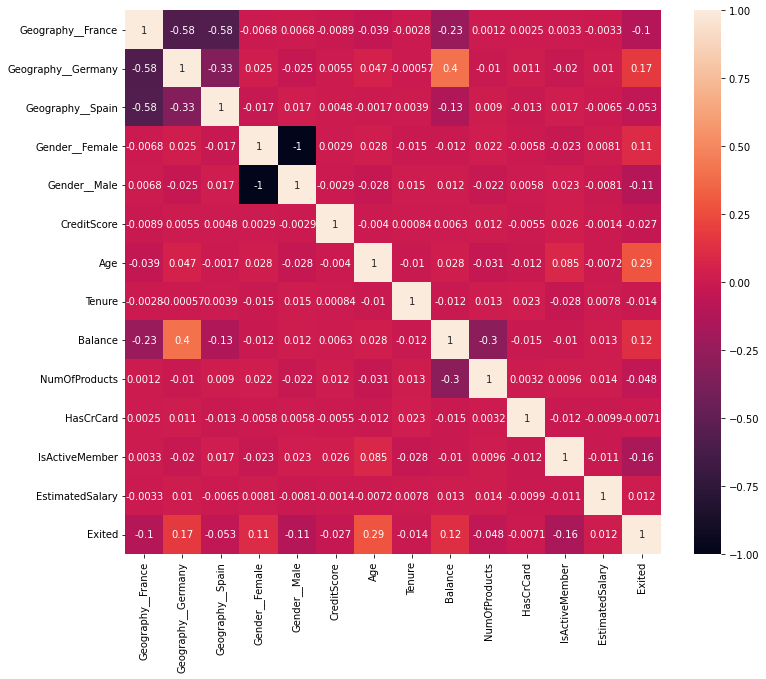

In [21]:
# Plot matrix of correlation between different variables
plot_heatmap(df_number)

In [22]:
# Get best features to analyze
list_best_features = get_best_features(df_number.corr()[['Exited']],-0.04,0.04)
list_best_features

['Geography__France',
 'Geography__Germany',
 'Geography__Spain',
 'Gender__Female',
 'Gender__Male',
 'Age',
 'Balance',
 'NumOfProducts',
 'IsActiveMember']

In [23]:
# Assign data of target variable to y variable
y = df_number['Exited'].values
# Assign data of predictor variables to X variable
X = df_number[list_best_features[:]].values
# Split data into training data and test data. (3/4 data for training data and 1/4 for test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=0)

In [24]:
# Tuning parameters for ANN model
find_best_param_ann(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


Epoch 1/20
750/750 [==============================] - 2s 1ms/step - loss: 0.5842 - accuracy: 0.7865
Epoch 2/20
750/750 [==============================] - 1s 1ms/step - loss: 0.5183 - accuracy: 0.7963
Epoch 3/20
750/750 [==============================] - 1s 1ms/step - loss: 0.5140 - accuracy: 0.7963
Epoch 4/20
750/750 [==============================] - 1s 1ms/step - loss: 0.5118 - accuracy: 0.7963
Epoch 5/20
750/750 [==============================] - 1s 1ms/step - loss: 0.5077 - accuracy: 0.7963
Epoch 6/20
750/750 [==============================] - 1s 1ms/step - loss: 0.5053 - accuracy: 0.7963
Epoch 7/20
750/750 [==============================] - 1s 1ms/step - loss: 0.4977 - accuracy: 0.7963
Epoch 8/20
750/750 [==============================] - 1s 1ms/step - loss: 0.4909 - accuracy: 0.7963
Epoch 9/20
750/750 [==============================] - 1s 1ms/step - loss: 0.4838 - accuracy: 0.7963
Epoch 10/20
750/750 [==============================] - 1s 1ms/step - loss: 0.4788 - accuracy: 0.7964

In [ ]:
# Tuning parameters to fine the best model among Logistic Regression, Random Forest and SVM
find_best_model_lr_rf_svm(X_train, y_train, X_test, y_test)

Building models to find the best...

Model: Logistic Regression
Best parameters: {'mdl__C': 0.5, 'mdl__penalty': 'l2', 'mdl__solver': 'liblinear'}
Training score with best parameters: 0.811
Testing score with best parameters: 0.811 

Model: Random Forest
Best parameters: {'mdl__criterion': 'gini', 'mdl__max_depth': 10, 'mdl__min_samples_leaf': 3, 'mdl__min_samples_split': 10}
Training score with best parameters: 0.865
Testing score with best parameters: 0.863 

Model: Support Vector Machine
Best parameters: {'mdl__C': 10, 'mdl__kernel': 'rbf'}
Training score with best parameters: 0.859
Testing score with best parameters: 0.863 

The best model with highest accuracy on testing data: Support Vector Machine


In [ ]:
# Tuning parameters to fine the best model among KNN, Decision Tree, Naive Bayes and XGBoost
#find_best_model_knn_dt_nb_xgb(X_train, y_train, X_test, y_test)

Building models to find the best...

Model: KNN
Best parameters: {'mdl__algorithm': 'ball_tree', 'mdl__metric': 'minkowski', 'mdl__n_neighbors': 13, 'mdl__weights': 'uniform'}
Training score with best parameters: 0.859
Testing score with best parameters: 0.856 

Model: Decision Tree
Best parameters: {'mdl__criterion': 'entropy', 'mdl__max_depth': 7, 'mdl__min_samples_leaf': 10, 'mdl__min_samples_split': 3}
Training score with best parameters: 0.860
Testing score with best parameters: 0.856 

Model: Gaussian Naive Bayes
Best parameters: {'mdl__var_smoothing': 0.23101297000831597}
Training score with best parameters: 0.819
Testing score with best parameters: 0.817 

Model: XGBoost
Best parameters: {'mdl__eta': 0.01, 'mdl__eval_metric': 'logloss', 'mdl__max_depth': 4, 'mdl__n_estimators': 100, 'mdl__objective': 'binary:logistic', 'mdl__sampling_method': 'uniform'}
Training score with best parameters: 0.865
Testing score with best parameters: 0.866 

The best model with highest accuracy on

**Conlusion:**
The data is almost clean, so we are not difficul to perfom data wrangling. By using descriptive statistics and evaluation of correlation between variables, we can gather the best features to analyze. They are: 
  + geography
  + gender
  + age
  + balance
  + number of products
  + IsActiveMember

After tuning parameters for other models for this problem, we found that the best model is XGBoost with accuracy of **86.6%**. The tree based algorithms such as XGBoost, Decision Tree, KNN with ball tree, Random Forest give good results for this problem. 





### THANK YOU FOR READING ###
## AUTHOR ##
Tho Quy NGO
